In [3]:
import os
import sys
import numpy as np
import pandas as pd
sys.path.append('../lib/')
import matplotlib.pyplot as plt
from find_stars_isolated import *
from sklearn.metrics import mean_squared_error
from utils import get_fits_file, latex_settings

# Reading FITS files of F606w

In [4]:
filepath_data = '../Data/FITS/'
wavelen='F606w'
# Get images as 2-D numpy array from FITS file of F606w
fits_f606, image_f606 = get_fits_file(wavelen=wavelen, fits_path=filepath_data)

# info about F606w fits file
fits_f606.info()

Filename: ../Data/FITS/hlsp_deep47tuc_hst_acs_47tuc_F606w_v1_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    7127   (10510, 10403)   float32   


Filter out all negative values for the intensity because they don't have physical meaning.

In [5]:
image = image_f606.copy()

# Check how many negative values are there
print(image[image < 0].size / image.size)

# setting to 0 all negative values
image[image < 0] = 0

0.15048535457778456


Read stars dataset

In [11]:
names = ['ID', 'Xcor', 'Ycor', 'F606', 'eF606',
         'F814', 'eF814', 'chi', 'sharp']

filepath_data = '../Data/Catalog/' 
file = os.listdir(filepath_data)[0]
data = pd.read_csv(filepath_data + file, names=names,
                   delim_whitespace=True, skiprows=1)

data

,ID,Xcor,Ycor,F606,eF606,F814,eF814,chi,sharp
0,8,4462.947,140.859,28.197,0.1036,27.127,0.1068,6.106,0.7310
1,120,5002.486,186.138,20.843,0.0552,19.815,0.0661,10.690,0.4000
2,165,5003.574,195.421,27.014,0.2194,26.068,0.1349,10.651,0.1940
3,226,4448.493,207.417,30.193,0.3641,28.270,0.1636,4.059,-1.9585
4,351,5040.717,224.366,28.935,0.1669,28.941,0.2464,4.274,-0.7720
...,...,...,...,...,...,...,...,...,...
51475,899987,3417.467,10394.319,26.895,0.0783,25.602,0.1050,9.508,1.3140
51476,900088,3435.031,10396.730,23.152,0.0504,22.662,0.0505,8.823,-0.1330
51477,900094,3594.567,10397.340,27.209,0.0815,27.130,0.0900,4.311,0.9355
51478,900176,5155.093,10397.920,28.235,0.0984,26.477,0.0937,6.173,0.3190


Find all image's points with intensity values in a choosen range.

Motivate the choice for the intensity values:
for now we choose interval \[950, 1000\] in order to avoid the superposition of more stars that have high intensity

In [17]:
data

,ID,Xcor,Ycor,F606,eF606,F814,eF814,chi,sharp
0,8,4462.947,140.859,28.197,0.1036,27.127,0.1068,6.106,0.7310
1,120,5002.486,186.138,20.843,0.0552,19.815,0.0661,10.690,0.4000
2,165,5003.574,195.421,27.014,0.2194,26.068,0.1349,10.651,0.1940
3,226,4448.493,207.417,30.193,0.3641,28.270,0.1636,4.059,-1.9585
4,351,5040.717,224.366,28.935,0.1669,28.941,0.2464,4.274,-0.7720
...,...,...,...,...,...,...,...,...,...
51475,899987,3417.467,10394.319,26.895,0.0783,25.602,0.1050,9.508,1.3140
51476,900088,3435.031,10396.730,23.152,0.0504,22.662,0.0505,8.823,-0.1330
51477,900094,3594.567,10397.340,27.209,0.0815,27.130,0.0900,4.311,0.9355
51478,900176,5155.093,10397.920,28.235,0.0984,26.477,0.0937,6.173,0.3190


In [5]:
%%time

ids = find_coords_from_image(950, 1000, image)
ids.shape

CPU times: user 484 ms, sys: 141 ms, total: 625 ms
Wall time: 592 ms


(860188, 2)

 Plotting comparison between all stars and filtered ones.

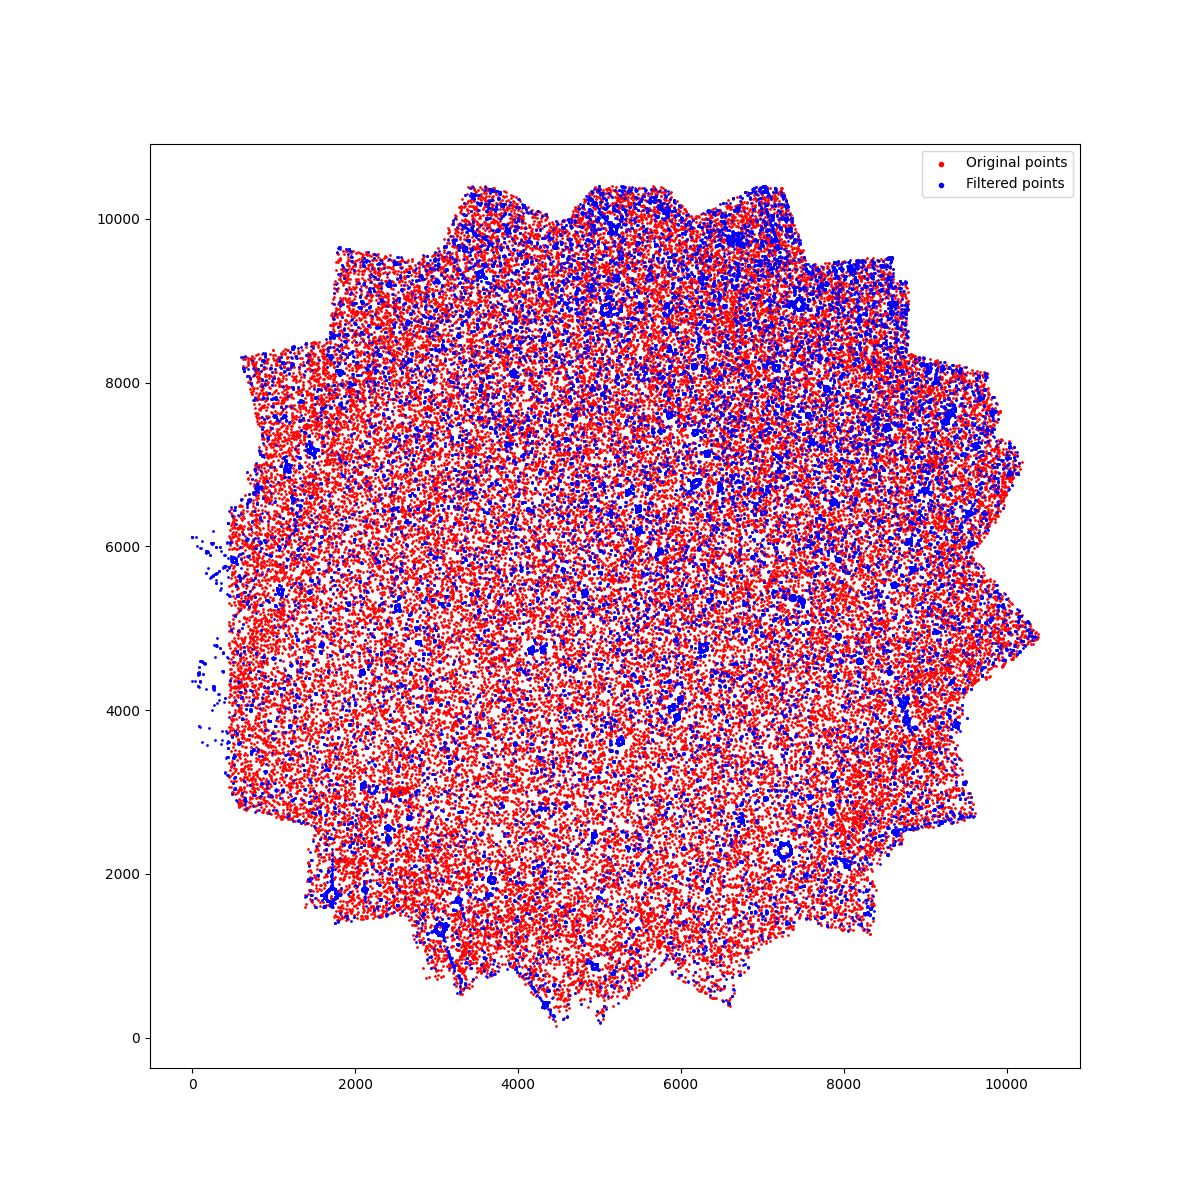

In [7]:
plt.figure(figsize=(12, 12))
plt.scatter(data['Xcor'], data['Ycor'], s=1, c='r', label='Original points')
plt.scatter(ids[:,0], ids[:,1], s=1, c='b', label='Filtered points')
plt.legend(markerscale=3)

In order to further filter the points and find isolated stars, we use graph-tool package. 
Create a geometric graph where all the coordinates found before are vertices. This points are connected in an euclidean space which are at a distance equal to or smaller than a given radius.

In [6]:
%%time

bb = 15.
dist = np.sqrt(2) * bb
g = geometric_graph_stars(coords=ids, distance=dist)

g

CPU times: user 6min, sys: 12.5 s, total: 6min 12s
Wall time: 46.7 s


<Graph object, undirected, with 860188 vertices and 101340765 edges, 2 internal vertex properties, at 0x7fd756c2b940>

In [ ]:
%%time

filepath_images = '../Images/'
graph_draw(g=g, pos=g.vp.pos)
save_graph_plot(Graph=g, file=filepath_images + f'geometric_graph_{wavelen}.png')

In [7]:
%%time


# Filter out all vertices with at least 1 edge.
gv = GraphView(g, vfilt=g.degree_property_map("out").a==0)
gv

CPU times: user 46.9 ms, sys: 78.1 ms, total: 125 ms
Wall time: 104 ms


<GraphView object, undirected, with 519 vertices and 0 edges, 2 internal vertex properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fd75671a9a0, at 0x7fd76feb77c0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fd75671a9a0, at 0x7fd75671aa30>, False), at 0x7fd75671a9a0>

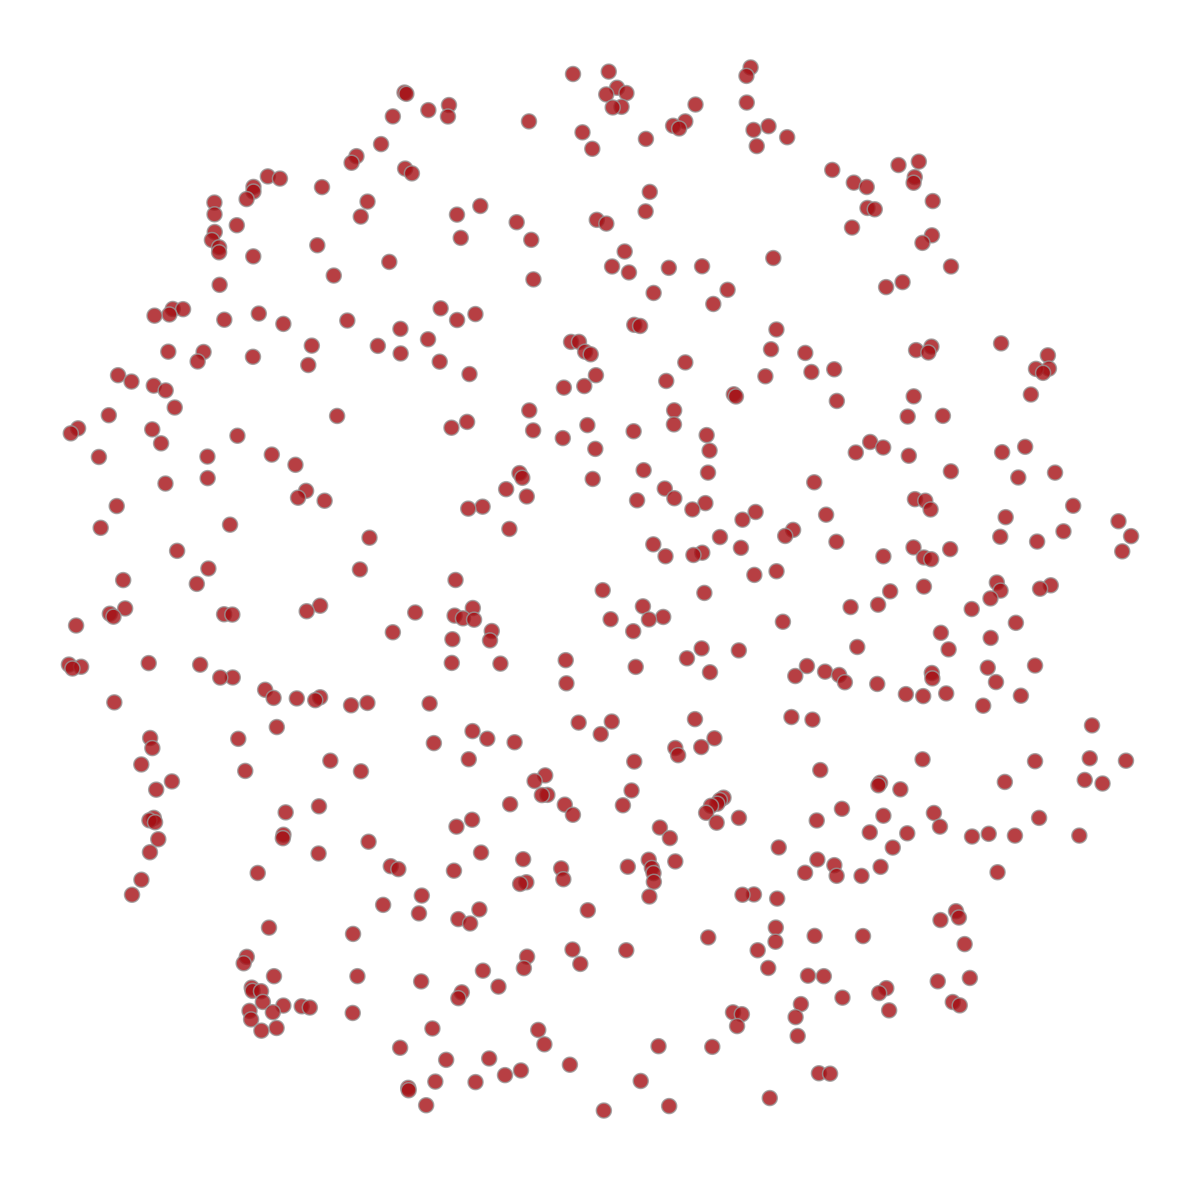

CPU times: user 5.73 s, sys: 1.98 s, total: 7.72 s
Wall time: 7.74 s


In [8]:
%%time


filepath_images = '../Images/'
graph_draw(gv, gv.vp.pos)
#save_graph_plot(Graph=gv, file=filepath_images + f'geometric_graph_noedges_{wavelen}.png')
plt.close()

In [9]:
%%time

ids_filt = gv.vp.pos.get_2d_array([0, 1]).T

del g, gv

CPU times: user 1.31 s, sys: 156 ms, total: 1.47 s
Wall time: 1.48 s


In [10]:
cor = data[['Xcor', 'Ycor', 'ID']].to_numpy()

Find all stars ID in the dataset with the closest coordinates respect the image indexis position.

In [11]:
%%time


IDs_filt = find_IDs_from_data(dataset=cor, ids=ids_filt, npixel=2.)
len(IDs_filt)

CPU times: user 953 ms, sys: 62.5 ms, total: 1.02 s
Wall time: 1.25 s


392

With the jit compiled function find_IDs_jit(), we obtain a speed up of around 20% respect to find_IDs().

In [12]:
len(np.unique(IDs_filt[:,0]))

392

In [7]:
df_bad = pd.read_csv(filepath_results + 'bad_stars_ID_F606w.txt')

In [9]:
filepath_results = '../Results/'

df = pd.read_csv(filepath_results + 'fit_results_F606w_gauss2d.csv')
df[mask]

,ID,Ai,xi,yi,A,x0,y0,sigma_x,sigma_y,theta,r2
1,52218.0,1720.054565,3559.0,1067.0,0.989116,3559.527661,1067.453909,1.536470,1.464358,-0.501849,0.966501
12,95763.0,4824.379395,6656.0,1468.0,0.923279,6655.657205,1468.208305,1.571991,1.536281,-0.045182,0.960362
17,131475.0,1708.534668,4297.0,1749.0,0.883332,4296.737776,1749.025517,1.533743,1.491052,-0.776555,0.969919
19,139364.0,1170.704834,5047.0,1819.0,0.952026,5047.247071,1819.428381,1.509263,1.500241,-0.012465,0.969210
25,153304.0,1383.010498,6329.0,1947.0,0.896320,6328.657487,1947.098024,1.564207,1.535911,-0.267274,0.994663
...,...,...,...,...,...,...,...,...,...,...,...
861,859401.0,1464.358643,6458.0,9806.0,0.896744,6457.745982,9806.037258,1.696833,1.622330,0.025144,0.989532
866,867161.0,967.179199,4079.0,9895.0,0.894075,4079.348673,9894.909869,1.679593,1.586625,-0.255485,0.983388
867,868570.0,1211.681885,6977.0,9910.0,0.846548,6977.178137,9909.609707,1.805178,1.714130,-0.211065,0.964575
874,876309.0,1050.422363,3947.0,9997.0,0.925746,3946.474640,9997.451872,1.544675,1.484740,0.029711,0.975629


In [8]:
mask = (df.r2 > 0.95) & ~df.ID.isin(df_bad.bad_ID) & (df.A < 2)

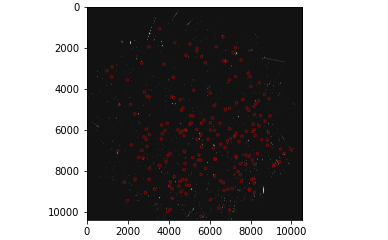

In [16]:
%matplotlib widget
fig, ax = latex_settings()

ax.imshow(image_f606, cmap='gray')
ax.scatter(data.loc[data.ID.isin(df.loc[mask, 'ID']), 'Xcor'], 
            data.loc[data.ID.isin(df.loc[mask, 'ID']), 'Ycor'],
            color='b', s=0.1, marker=',', label='Dataset pts')
ax.scatter(df.loc[mask, 'xi'], df.loc[mask, 'yi'], alpha=0.4, marker='o', color='r',
           fc='None', s=6., label='Image pts')
plt.show()
filepath_images = '../Images/'
plt.savefig(filepath_images + f'stars_ID_identified_{wavelen}_final.png',
            dpi=800, transparent=True)

In [18]:
df = pd.DataFrame(IDs_filt, columns=['ID', 'Xcor', 'Ycor'])
df = df.astype('int32')
filepath_results = '../Results/'
df.to_csv(filepath_results + f'ID_coords_image_{wavelen}.csv', index=False)

df

,ID,Xcor,Ycor
0,12547,3284,633
1,12908,5203,639
2,34368,4461,898
3,34410,5962,898
4,41545,5903,966
...,...,...,...
387,881137,4231,10055
388,885435,5534,10111
389,885828,3562,10117
390,898323,3474,10344


In [1]:
def get_star_box(ID: int, IDs: np.ndarray = df.to_numpy(),
                 img: np.ndarray = image, bb: int = 15, norm=True) -> np.array:
    """Get the box with the star's maximum intensity at center.

    Args:
        ID (float): star ID;
        IDs (np.ndarray, optional): ID of all isolated stars on the
                                    image. Defaults to df.to_numpy().
        img (np.ndarray, optional): data from fits file.
                                    Defaults to image.
        bb (int, optional): half side of the squared box.
                            Defaults to 15.

    Returns:
        np.array: star's box.
    """
    xc, yc = IDs[IDs[:,0] == ID, 1:].flatten()
    mat = img.copy() 
    box = mat[yc - bb:yc + bb, xc - bb: xc + bb]
    Ai = np.max(box)
    xi = xc - bb + np.where(box == Ai)[1][0]
    yi = yc - bb + np.where(box == Ai)[0][0]
    
    # check if max intensity is at central pixel
    if [xc, yc] != [xi, yi]:
        box = mat[yi - bb: yi + bb, xi - bb: xi + bb]
        xc, yc = xi, yi
    
    if norm:    
        box /= Ai
    else:
        pass
    
    return box, xc, yc, Ai

NameError: name 'df' is not defined

In [ ]:
%matplotlib widget
filepath_images = '../Images/'

for ID in df.ID:
    box, *param = get_star_box(ID)
    plt.imshow(box)
    plt.show()
    plt.savefig(filepath_images + f'BOX/prova/box_{ID}.png', dpi=800, transparent=True)
    plt.close()

In [17]:
df_old = pd.read_csv(filepath_results + f'ID_coords_image_{wavelen}.csv')

df_old

,ID,Xcor,Ycor
0,7873,4703,542
1,12547,3284,633
2,13066,4497,644
3,23114,4082,780
4,23342,5892,782
...,...,...,...
1177,893600,5870,10241
1178,894495,6753,10257
1179,897539,7124,10323
1180,898640,5807,10352


In [31]:
df_bad_ID = pd.read_csv(filepath_results + 'bad_stars_ID_F606w.txt')
df_bad_ID

,bad_ID,uncertain_ID
0,232910,12547
1,234978,250376
2,319567,384620
3,343731,457840
4,385646,487857
5,429954,493989
6,514206,524937
7,537647,636768
8,563535,686745
9,582257,760513


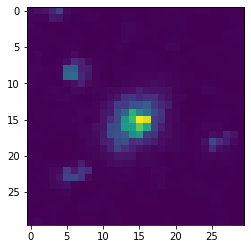

In [38]:
box = get_star_box(12547)
plt.imshow(box)

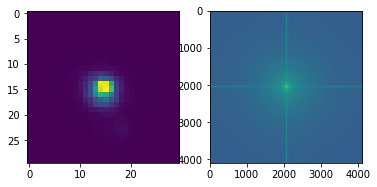

In [42]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(box)
ax[1].imshow(np.log(PSF))

In [43]:
bb = box.shape[0] // 2
xc, yc = np.where(PSF==PSF.max())
xc, yc = xc[0], yc[0]
PSF_cut = PSF[yc-bb:yc+bb, xc-bb:xc+bb]

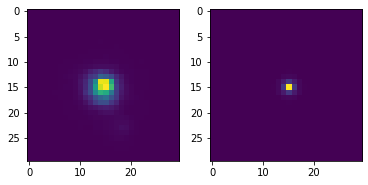

In [44]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(box)
ax[1].imshow(PSF_cut)

In [45]:
box_fft = np.fft.fft2(box)
OTF = np.fft.fft2(PSF_cut) 

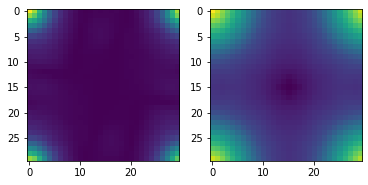

In [46]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.abs(box_fft))
ax[1].imshow(np.abs(OTF))

In [47]:
# shift max of frequecies at 0 for OTF and box_fft
box_fft_shift = np.fft.fftshift(box_fft)
OTF_shift = np.fft.fftshift(OTF)

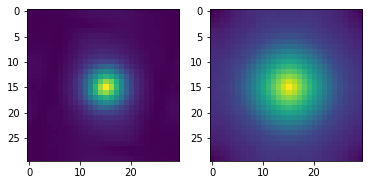

In [48]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.abs(box_fft_shift))
ax[1].imshow(np.abs(OTF_shift))

In [49]:
real_obj_F = box_fft_shift / OTF_shift

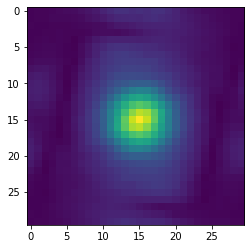

In [50]:
plt.imshow(np.abs(real_obj_F))

In [51]:
real_obj_shift = np.fft.ifft2(real_obj_F)

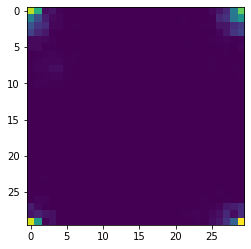

In [52]:
plt.imshow(np.abs(real_obj_shift))

In [53]:
real_obj = np.abs(np.fft.ifftshift(real_obj_shift))

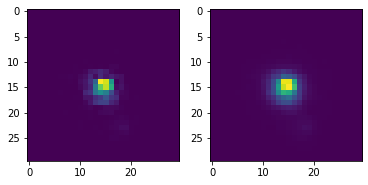

In [56]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(real_obj)
ax[1].imshow(box)

0.0014858205130756279


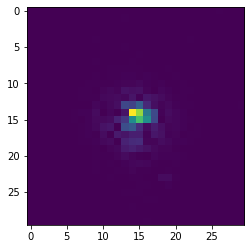

In [55]:
residual = box - real_obj
mse = mean_squared_error(real_obj, box)
print(mse)
plt.imshow(np.abs(residual))

# Reading FITS files of F814

In [30]:
# Get images as 2-D numpy array from FITS file of F814w
wavelen='F814w'
fits_f814, image_f814 = get_fits_file(wavelen=wavelen, fits_path=filepath_data)

# info about F814w fits file
fits_f814.info()

Filename: ../Data/FITS/hlsp_deep47tuc_hst_acs_47tuc_F814w_v1_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    7595   (10065, 10395)   float32   


Filter out all negative values for the intensity because they don't have physical meaning.

In [32]:
image = image_f814.copy()

# Check how many negative values are there
print(image[image < 0].size / image.size)

# setting to 0 all negative values
image[image < 0] = 0

0.15389321980479456


In [33]:
%%time

ids = find_coords_from_image(950, 1000, image)
ids.shape

CPU times: user 539 ms, sys: 209 ms, total: 748 ms
Wall time: 766 ms


(47407, 2)

In [34]:
%%time

bb = 15.
dist = np.sqrt(2) * bb
g = geometric_graph_stars(coords=ids, distance=dist)

g

CPU times: user 943 ms, sys: 1.82 ms, total: 945 ms
Wall time: 388 ms


<Graph object, undirected, with 47407 vertices and 288559 edges, 2 internal vertex properties, at 0x7f86b371c4f0>

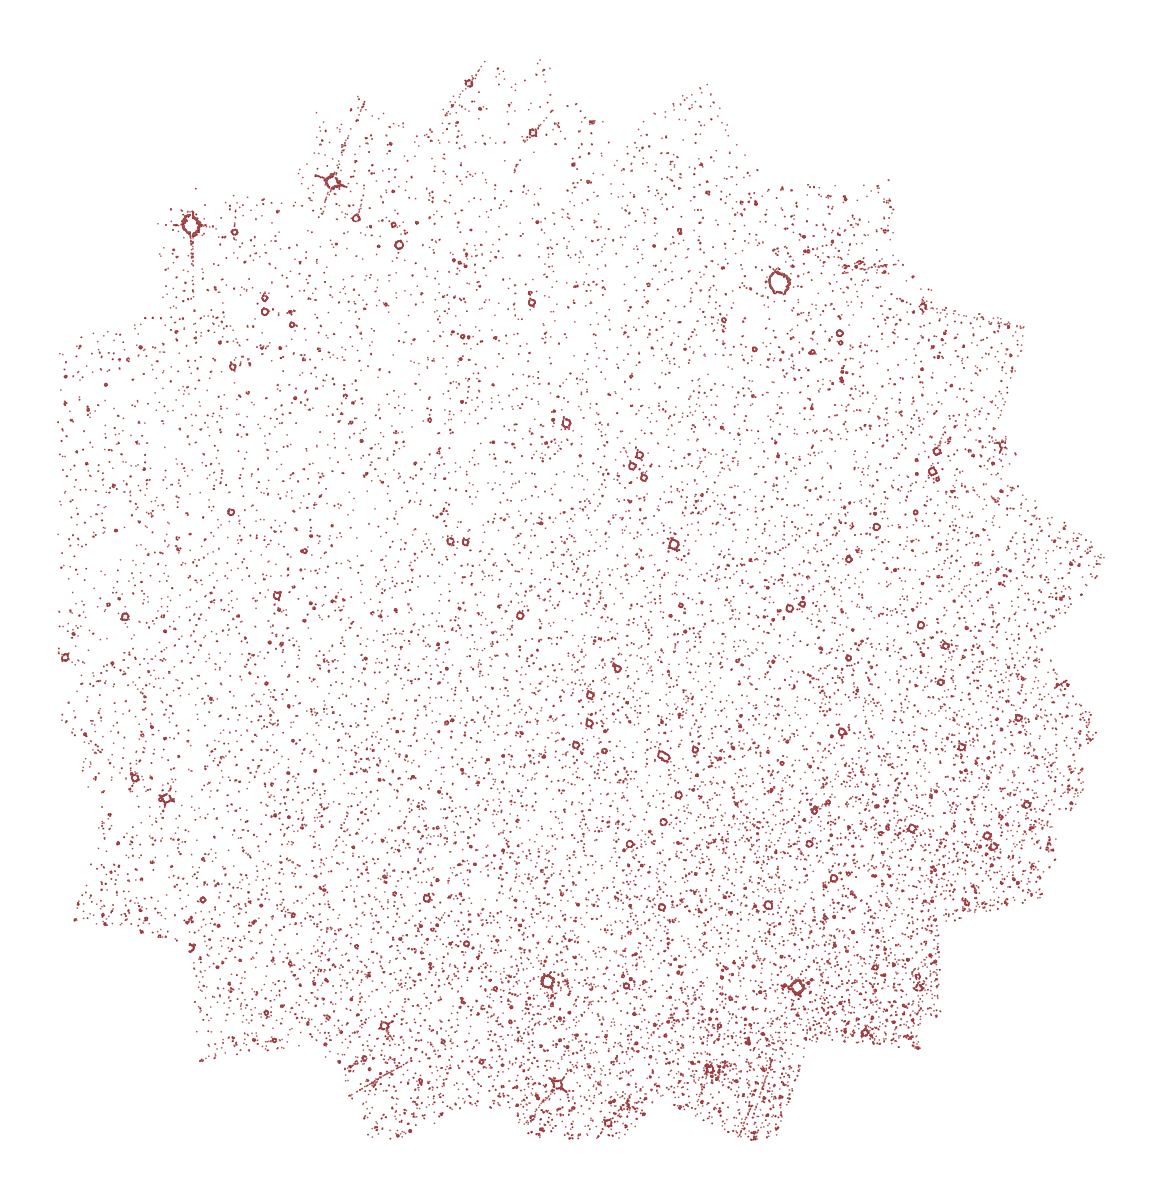

CPU times: user 16.8 s, sys: 0 ns, total: 16.8 s
Wall time: 16.5 s


In [35]:
%%time

filepath_images = '../Images/'
graph_draw(g=g, pos=g.vp.pos)
save_graph_plot(Graph=g, file=filepath_images + f'geometric_graph_{wavelen}.png')

In [37]:
%%time


# Filter out all vertices with at least 1 edge.
gv = GraphView(g, vfilt=g.degree_property_map("out").a==0)
gv

CPU times: user 17.2 ms, sys: 0 ns, total: 17.2 ms
Wall time: 4.31 ms


<GraphView object, undirected, with 4672 vertices and 0 edges, 2 internal vertex properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f86b371d990, at 0x7f86b37339d0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f86b371d990, at 0x7f86b3733850>, False), at 0x7f86b371d990>

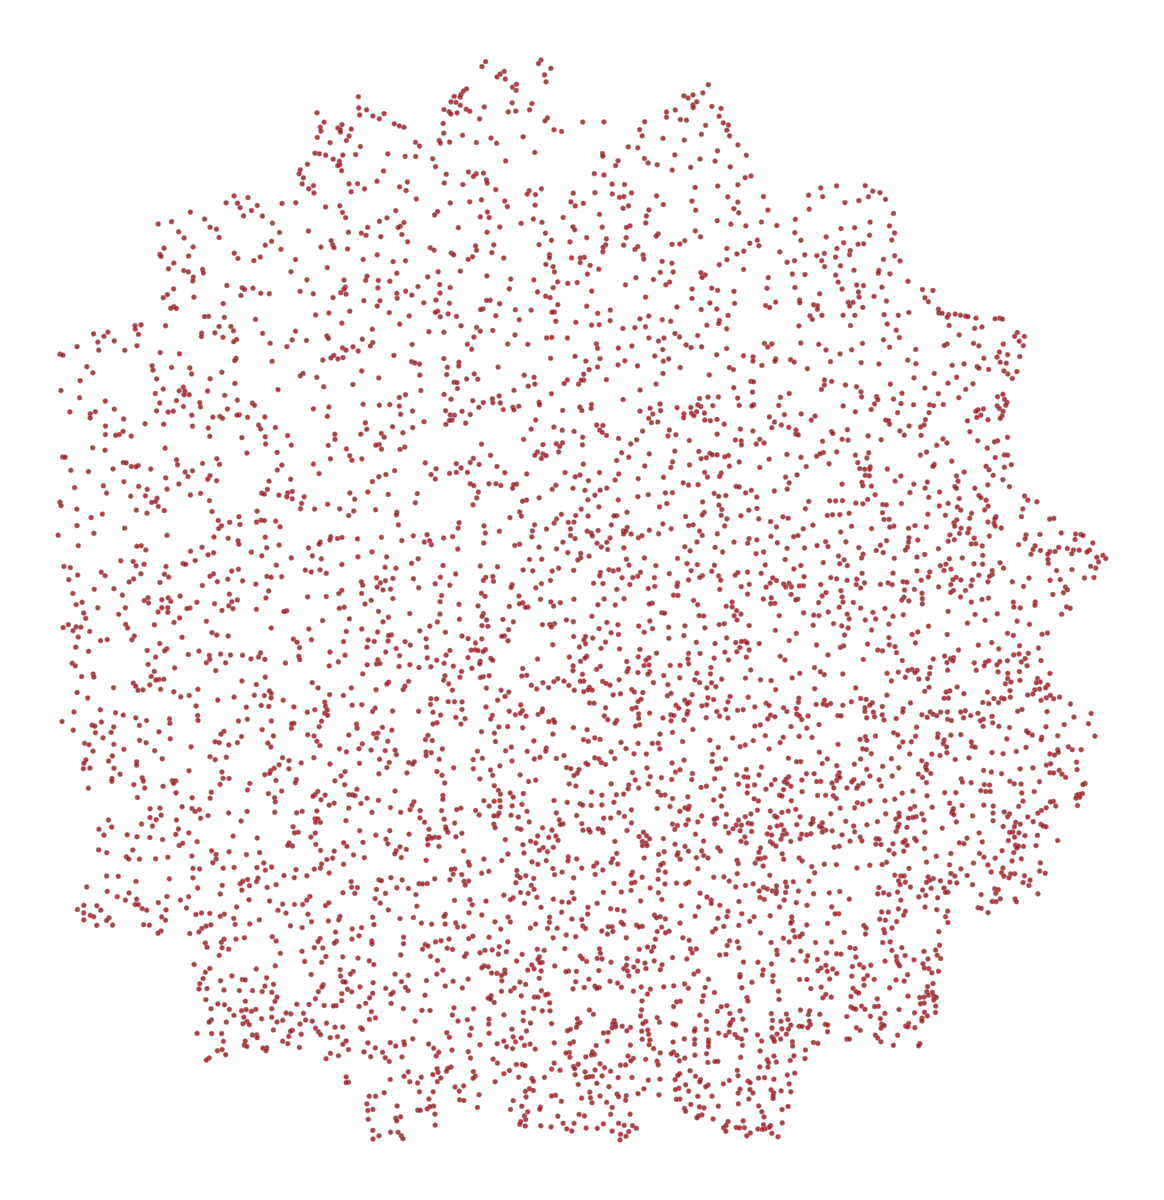

CPU times: user 801 ms, sys: 0 ns, total: 801 ms
Wall time: 523 ms


In [ ]:
%%time


filepath_images = '../Images/'
graph_draw(gv, gv.vp.pos)
save_graph_plot(Graph=gv, file=filepath_images + f'geometric_graph_noedges_{wavelen}.png')

In [38]:
%%time

ids_filt = gv.vp.pos.get_2d_array([0, 1]).T

del g, gv

CPU times: user 62.7 ms, sys: 0 ns, total: 62.7 ms
Wall time: 18.8 ms


In [39]:
%%time


IDs_filt = find_IDs_from_data(dataset=cor, ids=ids_filt, npixel=2.)
len(IDs_filt)

CPU times: user 191 ms, sys: 0 ns, total: 191 ms
Wall time: 189 ms


30

In [40]:
len(np.unique(IDs_filt[:,0]))

30

In [ ]:
%matplotlib widget
fig, ax = latex_settings()

ax.imshow(image, cmap='gray')
ax.scatter(data.loc[data.ID.isin(IDs_filt[:, 0]), 'Xcor'], 
            data.loc[data.ID.isin(IDs_filt[:, 0]), 'Ycor'],
            color='b', s=0.1, marker=',', label='Dataset pts')
ax.scatter(IDs_filt[:,1], IDs_filt[:,2], alpha=0.4, marker='o', color='r',
           fc='None', s=6., label='Image pts')
plt.show()
filepath_images = '../Images/'
plt.savefig(filepath_images + f'stars_ID_identified_{wavelen}.png',
            dpi=800, transparent=True)

In [42]:
df = pd.DataFrame(IDs_filt, columns=['ID', 'Xcor', 'Ycor'])
df = df.astype('int32')
filepath_results = '../Results/'
df.to_csv(filepath_results + f'ID_coords_image_{wavelen}.csv', index=False)

df

,ID,Xcor,Ycor
0,112180,1826,1596
1,150411,5172,1919
2,159371,6412,2006
3,175660,3590,2174
4,208655,3586,2547
5,214729,1864,2624
6,238668,8398,2856
7,271927,5179,3193
8,281175,1143,3299
9,372885,4819,4542


In [ ]:
for ID in df.ID:
    fit, _ = gauss2d_fitting(ID)
    plt.imshow(fit)
    plt.show()
    plt.savefig(filepath_images + f'Fit/{wavelen}/fit_{ID}.png', dpi=800, transparent=True)

In [ ]:
%matplotlib widget
filepath_images = '../Images/'

for ID in df.ID[363:]:
    box= get_star_box(ID)
    plt.imshow(box)
    plt.show()
    plt.savefig(filepath_images + f'BOX/{wavelen}/box_{ID}.png', dpi=800, transparent=True)
    plt.close()